In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers

import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from baukit import nethook
from operator import itemgetter

In [3]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float32)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

EleutherAI/gpt-j-6B ==> device: cuda:0, memory: 24320971760


In [9]:
#################################################
relation_id = "P17"
precision_at = 3
#################################################

with open("../data/counterfact.json") as f:
    counterfact = json.load(f)

objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
objects = [" "+ o['target_true']['str'] for o in objects]
objects = list(set(objects))
print("unique objects: ", len(objects), objects[0:5])

unique objects:  95 [' Malta', ' Bahamas', ' Brazil', ' Bermuda', ' Israel']


In [39]:
from relations.corner import CornerEstimator
corner_estimator = CornerEstimator(model=model, tokenizer=tokenizer)

In [40]:
simple_corner = corner_estimator.estimate_simple_corner(objects, scale_up=70)
print(simple_corner.norm().item(), corner_estimator.get_vocab_representation(simple_corner))

48.699092864990234 [' Italy', ' Spain', ' France', ' Germany', ' India']


In [41]:
lin_inv_corner = corner_estimator.estimate_lin_inv_corner(objects, target_logit_value=50)
print(lin_inv_corner.norm().item(), corner_estimator.get_vocab_representation(lin_inv_corner))

calculating inverse of unbedding weights . . .
59.5070686340332 [' Italy', ' Greece', ' Poland', ' Argentina', ' Germany']


initial representation:  ['members', 'Kind', 'Gate', 'quite', 'Join']


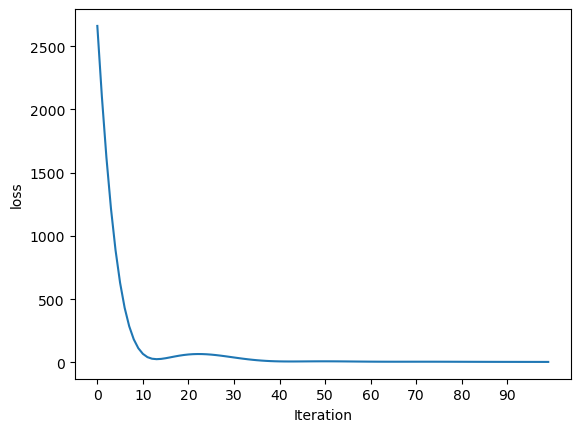

final representation:  [' Nigeria', ' Bangladesh', ' Finland', ' Thailand', ' Belgium']
50.91480255126953


In [42]:
grad_dsc_corner = corner_estimator.estimate_corner_with_gradient_descent(objects, target_logit_value=50, verbose=True)
print(grad_dsc_corner.norm().item())

In [46]:
avg_corner = corner_estimator.estimate_average_corner_with_gradient_descent(objects, average_on=5, target_logit_value=50, verbose=False)
print(avg_corner.norm().item(), corner_estimator.get_vocab_representation(avg_corner))

40.769771575927734 [' Ukraine', ' Finland', ' Nigeria', ' Bangladesh', ' Cyprus']


In [47]:
def P17__check_with_test_cases(relation_operator):

    test_cases = [
        ("The Great Wall", -1, "China"),
        ("Niagara Falls", -2, "Canada"),
        ("Valdemarsvik", -1, "Sweden"),
        ("Kyoto University", -2, "Japan"),
        ("Hattfjelldal", -1, "Norway"),
        ("Ginza", -1, "Japan"),
        ("Sydney Hospital", -2, "Australia"),
        ("Mahalangur Himal", -1, "Nepal"),
        ("Higashikagawa", -1, "Japan"),
        ("Trento", -1, "Italy"),
        ("Taj Mahal", -1, "India"),
        ("Hagia Sophia", -1, "Turkey"),
        ("Colosseum", -1, "Italy"),
        ("Mount Everest", -1, "Nepal"),
        ("Valencia", -1, "Spain"),
        ("Lake Baikal", -1, "Russia"),
        ("Merlion Park", -1, "Singapore"),
        ("Cologne Cathedral", -1, "Germany"),
        ("Buda Castle", -1, "Hungary")
    ]

    for subject, subject_token_index, target in test_cases:
        objects = relation_operator(
            subject,
            subject_token_index=subject_token_index,
            device=model.device,
            return_top_k=5,
        )
        print(f"{subject}, target: {target}   ==>   predicted: {objects}")

In [49]:
relation = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = '{} is located in the country of',
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = simple_corner
)
P17__check_with_test_cases(relation)

The Great Wall, target: China   ==>   predicted: [' China', ' India', ' Japan', ' Russia', ' Thailand']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', ' India', ' France', ' Italy', ' Australia']
Valdemarsvik, target: Sweden   ==>   predicted: [' Sweden', ' Norway', ' Germany', ' Finland', ' Denmark']
Kyoto University, target: Japan   ==>   predicted: [' Japan', ' France', ' Thailand', ' Italy', ' India']
Hattfjelldal, target: Norway   ==>   predicted: [' Norway', ' Sweden', ' India', ' Germany', ' Switzerland']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Italy', ' France', ' China', ' Thailand']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' France', ' Spain', ' Russia', ' China']
Mahalangur Himal, target: Nepal   ==>   predicted: [' India', ' Pakistan', ' China', ' Japan', ' Nepal']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' Spain', ' France', ' Italy', ' Canada']
Trento, target: Italy   ==>   predicted: [' Italy', ' Sp

In [50]:
relation = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = '{} is located in the country of',
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = lin_inv_corner
)
P17__check_with_test_cases(relation)

The Great Wall, target: China   ==>   predicted: [' China', ' India', ' Hungary', ' Thailand', ' Argentina']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', ' India', ' Italy', ' Finland', ' Germany']
Valdemarsvik, target: Sweden   ==>   predicted: [' Sweden', ' Norway', ' Finland', ' Denmark', ' Germany']
Kyoto University, target: Japan   ==>   predicted: [' Japan', ' France', ' Italy', ' Thailand', ' Indonesia']
Hattfjelldal, target: Norway   ==>   predicted: [' Norway', ' Sweden', ' Switzerland', ' Germany', ' India']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Italy', ' France', ' Thailand', ' India']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' France', ' Spain', ' Argentina', ' Germany']
Mahalangur Himal, target: Nepal   ==>   predicted: [' India', ' Argentina', ' Italy', ' Germany', ' Pakistan']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' Spain', ' Poland', ' Italy', ' France']
Trento, target: Italy   ==>   predict

In [51]:
relation = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = '{} is located in the country of',
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = grad_dsc_corner
)
P17__check_with_test_cases(relation)

The Great Wall, target: China   ==>   predicted: [' China', ' Taiwan', ' Thailand', ' Japan', ' Bangladesh']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', ' Falls', ' Philippines', ' Ontario', ' University']
Valdemarsvik, target: Sweden   ==>   predicted: [' Norway', ' Sweden', ' Finland', ' Denmark', ' Estonia']
Kyoto University, target: Japan   ==>   predicted: [' Japan', ' Philippines', ' Thailand', ' University', ' Netherlands']
Hattfjelldal, target: Norway   ==>   predicted: [' Norway', ' Sweden', ' Switzerland', ' Denmark', ' Austria']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Tokyo', ' Osaka', ' Taiwan', ' Thailand']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Russia', ' Ireland', ' Harbour', ' South']
Mahalangur Himal, target: Nepal   ==>   predicted: [' India', ' Pakistan', ' Nepal', ' Kenya', ' Bangladesh']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' Korea', ' Taiwan', ' Netherlands', ' Canada']
Trento, tar

In [52]:
relation = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = '{} is located in the country of',
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = avg_corner
)
P17__check_with_test_cases(relation)

The Great Wall, target: China   ==>   predicted: [' China', ' Taiwan', ' Japan', ' Thailand', ' Bangladesh']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', ' Falls', ' University', ' Philippines', ' Ontario']
Valdemarsvik, target: Sweden   ==>   predicted: [' Norway', ' Sweden', ' Denmark', ' Finland', ' Estonia']
Kyoto University, target: Japan   ==>   predicted: [' Japan', ' Philippines', ' University', ' Thailand', ' Netherlands']
Hattfjelldal, target: Norway   ==>   predicted: [' Norway', ' Sweden', ' Switzerland', ' Denmark', ' Iceland']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Tokyo', ' Osaka', ' Taiwan', ' Thailand']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Russia', ' Ireland', ' Israel', ' France']
Mahalangur Himal, target: Nepal   ==>   predicted: [' India', ' Pakistan', ' Nepal', ' Bangladesh', ' Kenya']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' Taiwan', ' Korea', ' Netherlands', ' Canada']
Trento, tar